In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model, preprocessing # For linear regression modelling
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split # For splitting the data for testing purposes
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import seaborn as sns # For visualisations
import statsmodels.api as sm # For linear regression modelling
from statsmodels.graphics.gofplots import qqplot

from statsmodels.graphics.api import abline_plot # For visualling evaluating predictions
import warnings # For handling error messages

In [3]:
#import the full, labelled data set
pots = pd.read_csv('Pots_clean_labelled.csv')
pots.head(1)

,productcode,price,maker,name,description,height,width,depth,materials,technique,firing,decoration,category
0,AM470Y165,47.0,Andy Mason,ovalled bowl cream satin motif,this stoneware bowl is wheel-thrown with a cre...,8.0,25.5,22.0,Stoneware,Thrown,Electric,Glaze,first


In [4]:
pots_encoded = pd.get_dummies(
                                pots.drop(columns=['productcode', 'category', 'name', 'maker', 'description']),
                                drop_first=True #Always drop one category as information is encoded in subsequent vars
                            )
pots_encoded.columns

Index(['price', 'height', 'width', 'depth', 'materials_Earthenware',
       'materials_Porcelain', 'materials_Stoneware', 'technique_Thrown',
       'firing_Gas', 'firing_Raku', 'firing_Wood', 'decoration_Lustre',
       'decoration_Sgraffito', 'decoration_Slip decoration',
       'decoration_Terra Sigillata'],
      dtype='object')

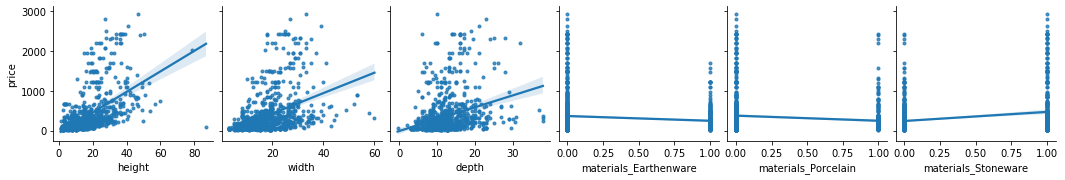

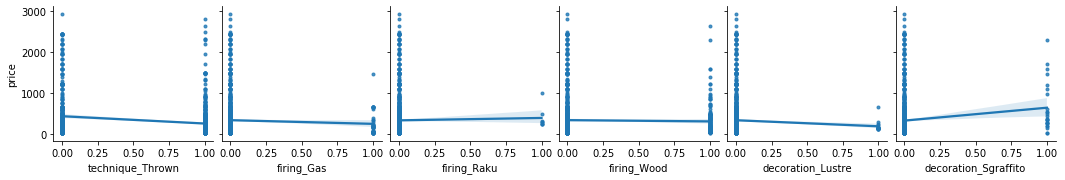

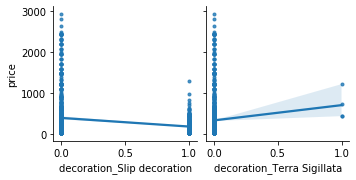

In [5]:
cols = pots_encoded.columns.drop('price')
n_cols = 6

for i in range(0, len(cols), n_cols):
    sns.pairplot(data=pots_encoded[pots_encoded['price'] < 3000], #exclude most expensive pots for visual purposes
             x_vars=cols[i:i+n_cols], 
             y_vars=['price'],
             markers='.',
             diag_kind=None, #needed to avoid broken pairplot logic (as of version 0.11.1)
             kind='reg')
    plt.show()

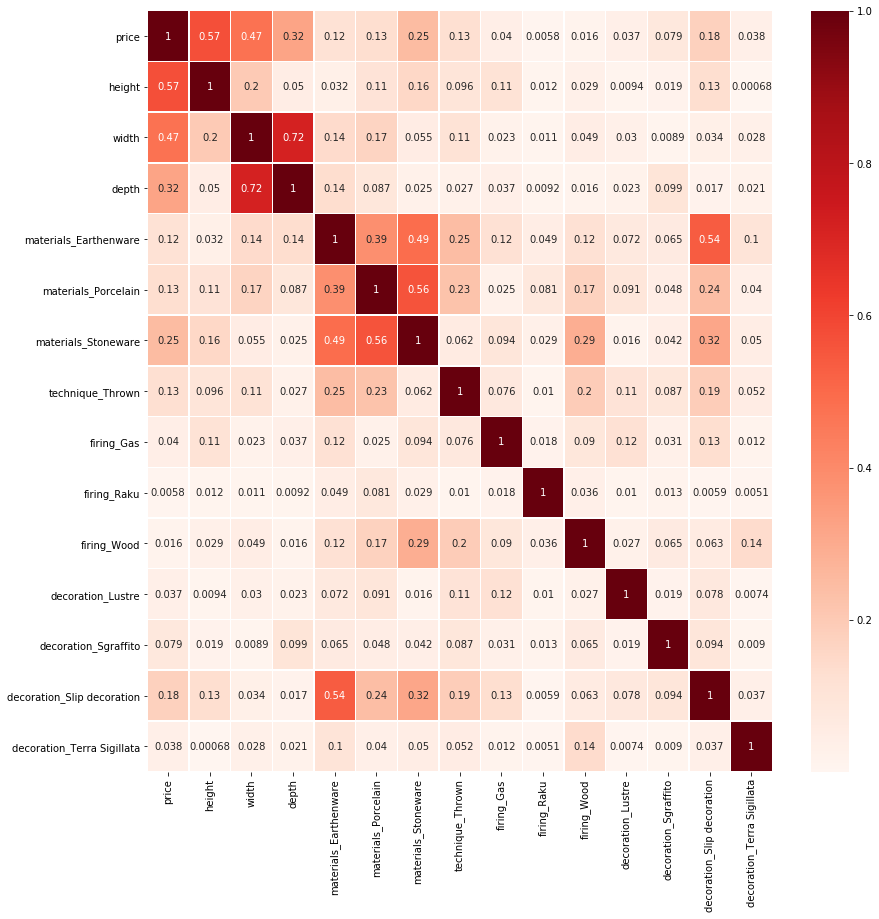

In [6]:
plt.figure(figsize=(14, 14))
sns.heatmap(abs(pots_encoded.corr()), annot = True, linewidths = 0.5, cmap = 'Reds')

There are three correlation clusters to take care of:
1. Width, depth
2. materials_Earthenware, materials_Porcelain, materials_Stoneware

Let's use the mean of width and depth and call it 'length'

In [7]:
pots_reg = pots_encoded.copy()

In [8]:
pots_reg['length'] = pots_reg[['depth', 'width']].mean(axis=1)
pots_reg.drop(columns=['depth', 'width'], inplace = True)

I will deal with the multicollinearity of the materials categorical variables using a regularized approach, if need be.

## Simple linear regression

In [9]:
X = pots_reg[['height']]
y = pots_reg['price']

In [10]:
print(X.shape, y.shape)

(1126, 1) (1126,)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(900, 1) (226, 1)
(900,) (226,)


In [12]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [13]:
print(lin_reg.intercept_)
print(lin_reg.coef_)

-99.86664687015747
[29.81254078]


Generate predictions

In [14]:
preds_train = lin_reg.predict(X_train)
preds_test = lin_reg.predict(X_test)

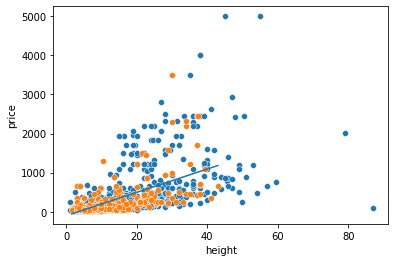

In [15]:

sns.scatterplot(x = 'height', y = y_train, data = X_train)
sns.scatterplot(x = 'height', y = y_test, data = X_test)
sns.lineplot(x = 'height', y = preds_test, data = X_test)

In [16]:
mae = mean_absolute_error(y_test, preds_test)
rmse = mean_squared_error(y_test, preds_test, squared=False)

print('MAE:', mae)
print('RMSE:', rmse)

MAE: 233.63755943251627
RMSE: 386.0784504407163


### Checking assumptions

1. Linearity
2. Normally Distribution of Residuals
3. Homoscedasticity
4. Independence

#### Linearity

Not great — although height has a decent linear relationship with price, at least on visual inspection, we can also see that the data is distributed quite widely. We can check this in our next assumption

#### Normal distribution of residuals

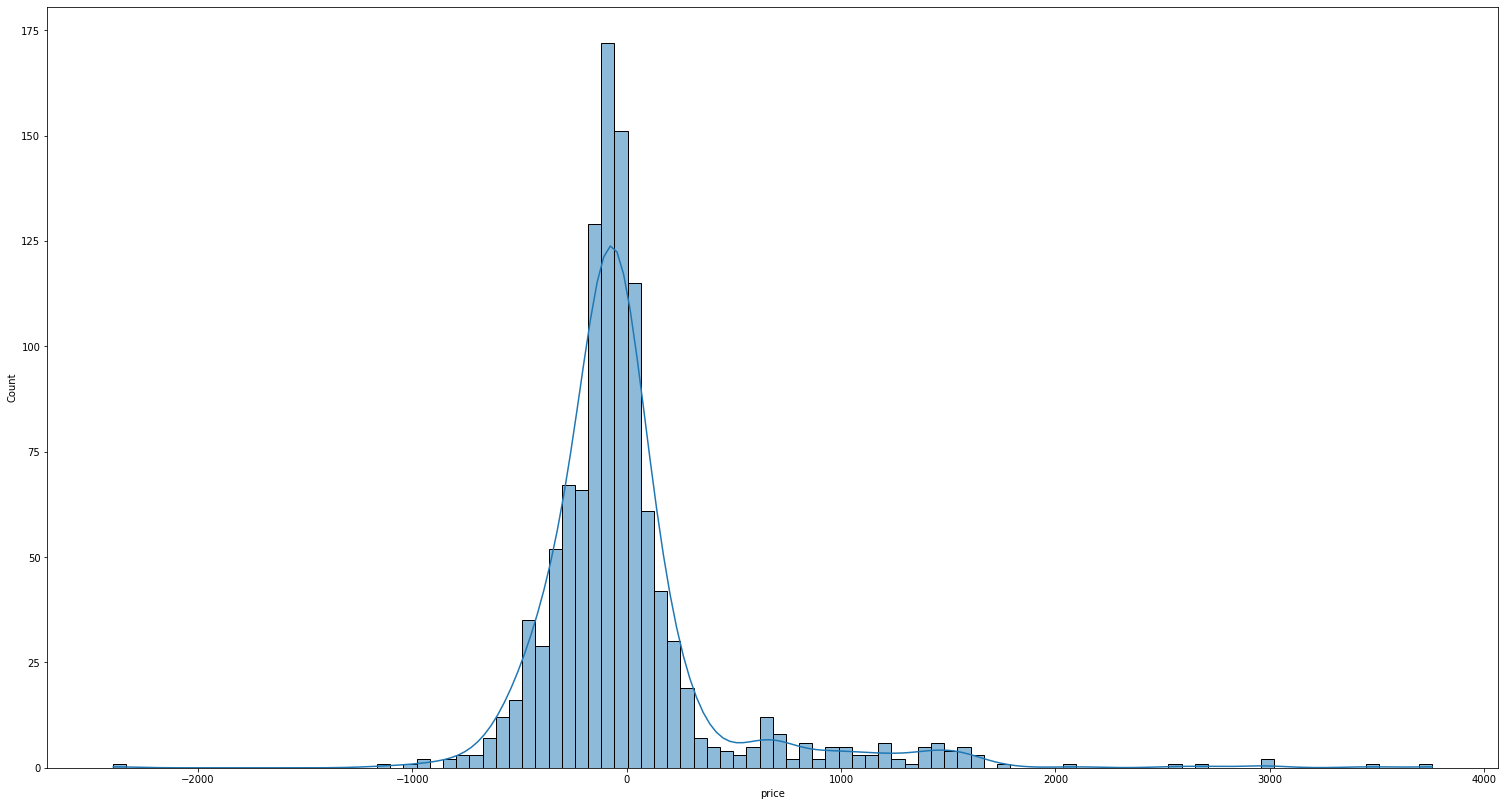

In [17]:
preds_all = lin_reg.predict(X)
residuals = y - preds_all

plt.figure(figsize=(26, 14))
sns.histplot(residuals, kde = True, bins = 100)

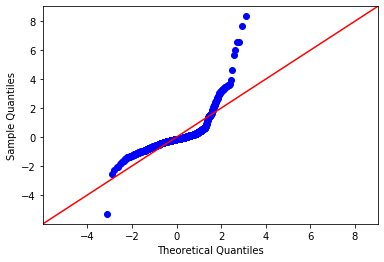

In [18]:
from statsmodels.graphics.gofplots import qqplot

qq = qqplot(residuals, line='45', fit=True)

#### Homoscedasticity

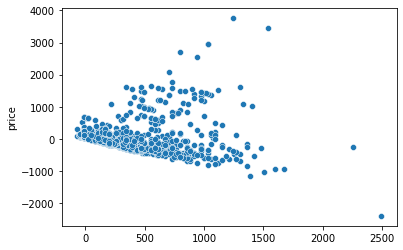

In [19]:
sns.scatterplot(x=preds_all, y=residuals)

Initial results with what is clearly the most important variable is already indicating that something will have to be done with the data in order to make it more appropriate for a regression analysis. 

To consider, and looking at the distribution of the residuals, is to apply some log-normal transformation. 

Additionally, I will consider stripping out the higher value pots, as it may well be that they are from a small and select number of makers only.

Firstly, let's try a multiple linear regression.

## Multiple linear regression

In [33]:
pots_reg.columns.drop(['price'])

Index(['height', 'materials_Earthenware', 'materials_Porcelain',
       'materials_Stoneware', 'technique_Thrown', 'firing_Gas', 'firing_Raku',
       'firing_Wood', 'decoration_Lustre', 'decoration_Sgraffito',
       'decoration_Slip decoration', 'decoration_Terra Sigillata', 'length'],
      dtype='object')

In [84]:
X = pots_reg[['height', 'materials_Earthenware', 'materials_Porcelain',
       'materials_Stoneware', 'technique_Thrown', 'firing_Gas', 'firing_Raku',
       'firing_Wood', 'decoration_Lustre', 'decoration_Sgraffito',
       'decoration_Slip decoration', 'decoration_Terra Sigillata', 'length']]
y = pots_reg['price']

print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

print(round(lin_reg.intercept_, 1))
print(dict(zip(X.columns, lin_reg.coef_)))

preds_train = lin_reg.predict(X_train)
preds_test = lin_reg.predict(X_test)
preds_all = lin_reg.predict(X)
residuals = y - preds_all

mae = mean_absolute_error(y_test, preds_test)
rmse = mean_squared_error(y_test, preds_test, squared=False)
r2 = r2_score(y_test, preds_test)

print('MAE:', round(mae, 1))
print('RMSE:', round(rmse, 1))
print('R^2:', round(r2, 3))

(1126, 13) (1126,)
-511.7
{'height': 24.279909923454674, 'materials_Earthenware': -95.16625374558616, 'materials_Porcelain': 64.73591763550472, 'materials_Stoneware': 215.4455463509288, 'technique_Thrown': -106.1985044766979, 'firing_Gas': -70.75239904355747, 'firing_Raku': -90.77098380830701, 'firing_Wood': -88.98822303707287, 'decoration_Lustre': -58.56656295132576, 'decoration_Sgraffito': 174.50795676726338, 'decoration_Slip decoration': -30.90060147916168, 'decoration_Terra Sigillata': 539.1756657333619, 'length': 35.281913510494626}
MAE: 229.5
RMSE: 339.8
R^2: 0.475


Text(0.5, 1.0, 'Price vs price predicted')

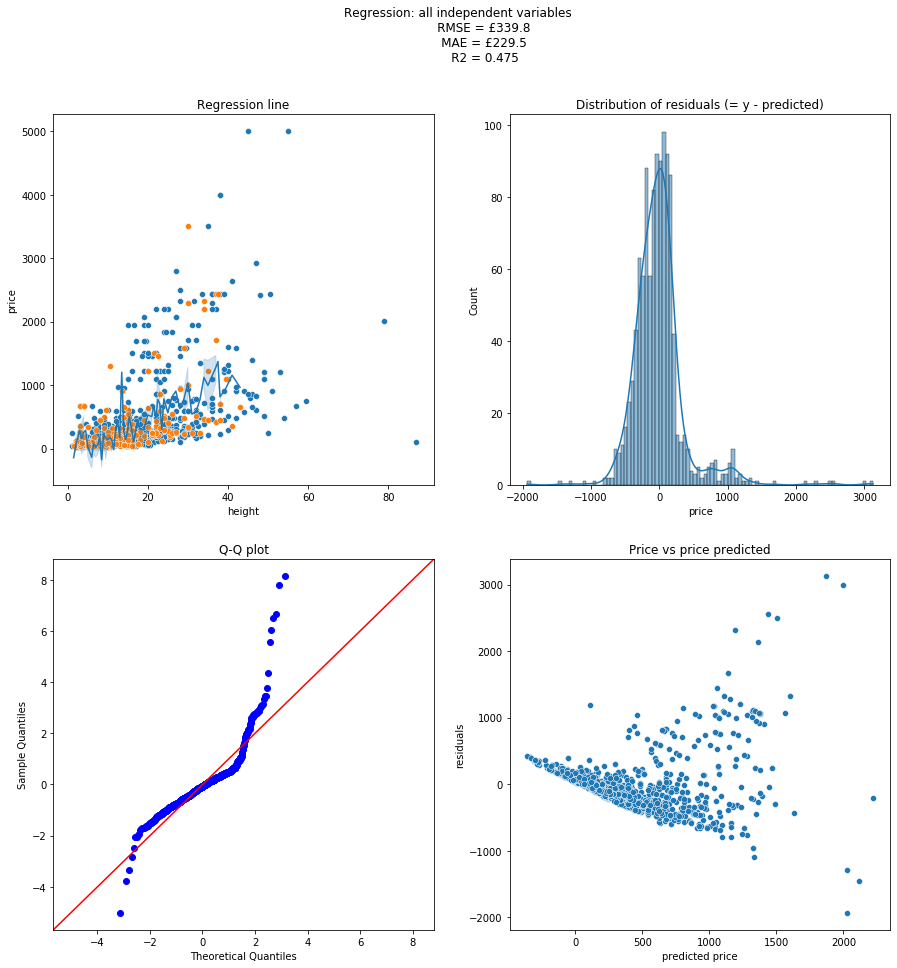

In [90]:
fig, axes = plt.subplots(2, 2,figsize=(15,15))

fig.suptitle("Regression: all independent variables\n \
             RMSE = £{} \n \
             MAE = £{} \n \
             R2 = {}".format(round(rmse, 1), round(mae, 1), round(r2,3)))

sns.scatterplot(x = 'height', y = y_train, data = X_train, ax=axes[0, 0])
sns.scatterplot(x = 'height', y = y_test, data = X_test, ax=axes[0, 0])
sns.lineplot(x = 'height', y = preds_test, data = X_test, ax=axes[0, 0])
axes[0, 0].set_title("Regression line")

sns.histplot(residuals, kde = True, bins = 100, ax=axes[0,1])
axes[0,1].set_title("Distribution of residuals (= y - predicted)")

qqplot(residuals, line='45', fit=True, ax=axes[1,0])
axes[1,0].set_title("Q-Q plot")

sns.scatterplot(x=preds_all, y=residuals, ax=axes[1,1])
axes[1,1].set_xlabel("predicted price")
axes[1,1].set_ylabel("residuals")
axes[1,1].set_title("Price vs price predicted")

## Multiple linear regression
with some variables removed according to heatmap

In [91]:
X = pots_reg[['height', 'materials_Earthenware', 'materials_Porcelain',
       'materials_Stoneware', 'technique_Thrown', 'firing_Gas', 'firing_Raku',
       'firing_Wood', 'decoration_Lustre', 'decoration_Sgraffito',
       'decoration_Slip decoration', 'decoration_Terra Sigillata', 'length']]
X = X.drop(columns=[""])

,height,materials_Earthenware,materials_Porcelain,materials_Stoneware,technique_Thrown,firing_Gas,firing_Raku,firing_Wood,decoration_Lustre,decoration_Sgraffito,decoration_Slip decoration,decoration_Terra Sigillata,length
0,8.0,0,0,1,1,0,0,0,0,0,0,0,23.75
1,8.0,0,0,1,1,0,0,0,0,0,0,0,23.50
2,3.0,0,0,1,1,0,0,0,0,0,0,0,20.15
3,3.0,0,0,1,1,0,0,0,0,0,0,0,20.15
4,3.0,0,0,1,1,0,0,0,0,0,0,0,19.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1121,10.0,0,1,0,1,0,0,0,0,0,1,0,8.05
1122,17.0,0,0,1,0,0,0,0,0,0,1,0,16.55
1123,15.0,0,0,0,0,0,0,0,0,0,1,0,17.30
1124,19.0,0,0,1,1,0,0,0,0,0,1,0,9.45
